<a href="https://colab.research.google.com/github/mgorsk1/gargabe-detector-app/blob/baseline/model/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os, glob

import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

Link to the data: https://drive.google.com/open?id=1m6-StcbywxvW95NsyibE7tl3PYRdlfcx

copy data to your google drive and modify `project_dir` below. 

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
project_dir = 'My Drive/projects/ING/Experiment_week/garbage_segmentation/'

data_train_dir = project_dir + 'data/raw/train/'
data_test_dir = project_dir + 'data/raw/test/'
models_dir = project_dir + 'models/'

target_size = (128, 128)

In [10]:
classes = os.listdir(data_train_dir)
classes

['metal', 'paper', 'glass', 'plastic', 'cardboard']

In [11]:
os.listdir(data_test_dir)

['cardboard', 'glass', 'paper', 'plastic', 'metal']

In [0]:
def stack_images_and_labels(data_dir, target_size=(224, 224), do_save=True):
    file_paths = glob.glob(data_dir + '*/*')

    df_files = pd.DataFrame(file_paths, columns=['file_path'])
    df_files = df_files.assign(label=df_files['file_path'].str.split('/').apply(lambda x: x[-2]))

    images_list, labels_list = [], []
    for _, row in tqdm(df_files.iterrows(), total=len(df_files)):
        file_path = row[0]
        label = row[1]

        image = tf.keras.preprocessing.image.load_img(file_path, target_size=target_size)
        image = tf.keras.preprocessing.image.img_to_array(image)

        images_list.append(image)
        labels_list.append(label)

    images = np.stack(images_list)
    labels = np.stack(labels_list)

    if do_save:
        np.save(data_dir.replace('raw', 'processed') + 'images.npy', images)
        np.save(data_dir.replace('raw', 'processed') + 'labels.npy', labels)

    return images, labels

In [13]:
images_train, labels_train = stack_images_and_labels(data_train_dir, target_size=target_size)

In [14]:
images_test, labels_test = stack_images_and_labels(data_test_dir, target_size=target_size)

In [15]:
images_train = np.load(data_train_dir.replace('raw', 'processed') + 'images.npy')
labels_train = np.load(data_train_dir.replace('raw', 'processed') + 'labels.npy')
images_test = np.load(data_test_dir.replace('raw', 'processed') + 'images.npy')
labels_test = np.load(data_test_dir.replace('raw', 'processed') + 'labels.npy')

images_train.shape, labels_train.shape, images_test.shape, labels_test.shape

((3989, 128, 128, 3), (3989,), (186, 128, 128, 3), (186,))

In [0]:
def plot_images(images, labels):
    indices = np.random.choice(range(len(images)), size=10)
    fig, axs = plt.subplots(2, 5, figsize=(15, 5))
    axs = [j for i in axs for j in i]
    for i, index in enumerate(indices):
        axs[i].imshow(images[index].astype(int)) 
        axs[i].set_title(labels[index])

    plt.tight_layout()

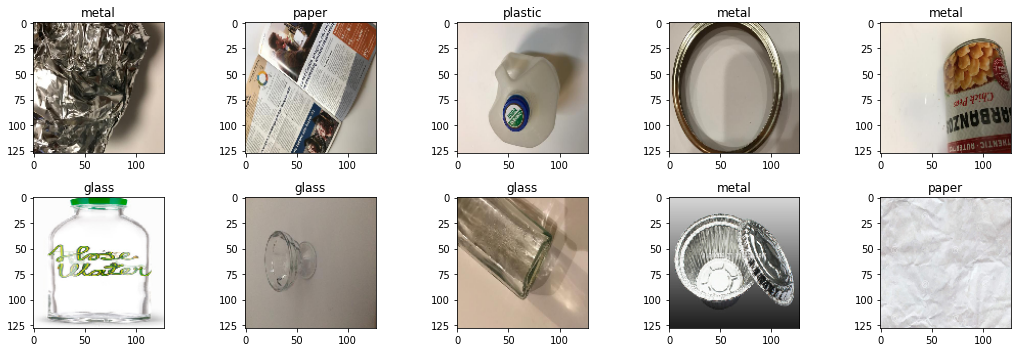

In [17]:
plot_images(images_train, labels_train)

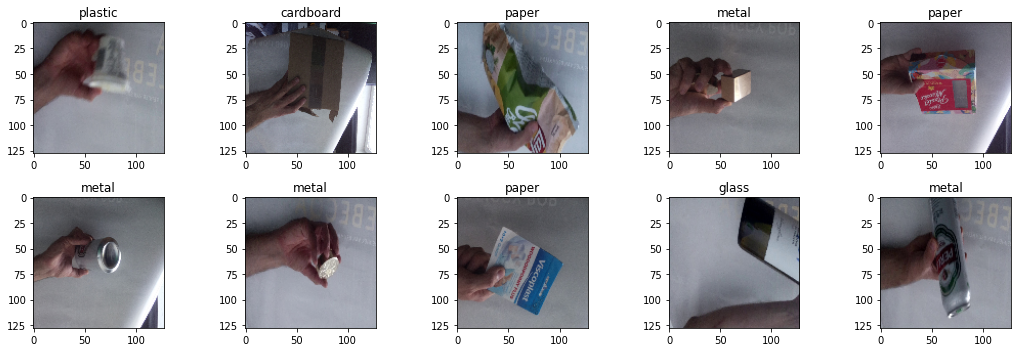

In [18]:
plot_images(images_test, labels_test)

In [0]:
def compute_image_embedding(images, model, preprocess_input, data_dir, do_save=True):
    images_preped = preprocess_input(np.copy(images))
    images_embedding = model.predict(images_preped, batch_size=32, verbose=1)
    if do_save:
        np.save(data_dir.replace('raw', 'processed') + 'images_embedding.npy', images_embedding)
    return images_embedding

In [22]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

model_base = tf.keras.applications.resnet50.ResNet50(include_top=False, input_shape=(128, 128, 3))

94773248/94765736 [==============================] - 1s 0us/step


In [23]:
images_embedding_train = compute_image_embedding(images_train, model_base, preprocess_input, data_train_dir)

125/125 [==============================] - 10s 83ms/step


In [24]:
images_embedding_test = compute_image_embedding(images_test, model_base, preprocess_input, data_test_dir)

6/6 [==============================] - 1s 151ms/step


In [25]:
images_embedding_train = np.load(data_train_dir.replace('raw', 'processed') + 'images_embedding.npy')
labels_train = np.load(data_train_dir.replace('raw', 'processed') + 'labels.npy')

images_embedding_train.shape, labels_train.shape

((3989, 4, 4, 2048), (3989,))

In [26]:
images_embedding_test = np.load(data_test_dir.replace('raw', 'processed') + 'images_embedding.npy')
labels_test = np.load(data_test_dir.replace('raw', 'processed') + 'labels.npy')

images_embedding_test.shape, labels_test.shape

((186, 4, 4, 2048), (186,))

In [27]:
images_embedding_train.mean(), images_embedding_train.std()

(0.63152826, 2.0108695)

In [28]:
images_embedding_test.mean(), images_embedding_test.std()

(0.79383963, 2.2164638)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [30]:
images_embedding_train, images_embedding_val, labels_train, labels_val = train_test_split(images_embedding_train, labels_train, random_state=1)
images_embedding_train.shape

(2991, 4, 4, 2048)

In [0]:
def to_categorical(labels, label_to_index):
    labels_int = pd.Series(labels).map(label_to_index)
    return tf.keras.utils.to_categorical(labels_int, num_classes=len(label_to_index)) 

In [0]:
label_to_index = dict(zip(classes, range(len(classes))))

labels_train_c = to_categorical(labels_train, label_to_index)
labels_val_c = to_categorical(labels_val, label_to_index)
labels_test_c = to_categorical(labels_test, label_to_index)

In [33]:
images_embedding_train.shape

(2991, 4, 4, 2048)

In [0]:
def make_model(model_base=None, embeddings_shape=None):
    if model_base:
        embeddings = model_base.output
        inputs = model_base.input

    elif embeddings_shape:
        embeddings = tf.keras.Input(shape=embeddings_shape)
        inputs = embeddings
    
    x = tf.keras.layers.BatchNormalization()(embeddings)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(100, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    output = tf.keras.layers.Dense(len(classes), activation='softmax')(x)

    return tf.keras.models.Model(inputs=inputs, outputs=output)

In [37]:
model_top = make_model(embeddings_shape=images_embedding_train.shape[1:])
model_top.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4, 4, 2048)]      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 2048)        8192      
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              32769000  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               100100    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0   

In [0]:
model_top.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False)
)

In [39]:
new_learning_rate = 0.001

print('current_learning_rate', tf.keras.backend.get_value(model_top.optimizer.lr))
tf.keras.backend.set_value(model_top.optimizer.lr, new_learning_rate)
print('current_learning_rate', tf.keras.backend.get_value(model_top.optimizer.lr))

current_learning_rate 0.001
current_learning_rate 0.001


In [41]:
model_top.fit(
    images_embedding_train, 
    labels_train_c,
    validation_data=(images_embedding_val, labels_val_c),
    validation_freq=10,
    batch_size=32, 
    epochs=100
)

Epoch 1/100
94/94 [==============================] - 2s 19ms/step - loss: 0.3482
Epoch 2/100
94/94 [==============================] - 2s 18ms/step - loss: 0.3158
Epoch 3/100
94/94 [==============================] - 2s 18ms/step - loss: 0.2307
Epoch 4/100
94/94 [==============================] - 2s 20ms/step - loss: 0.1426
Epoch 5/100
94/94 [==============================] - 2s 19ms/step - loss: 0.1650
Epoch 6/100
94/94 [==============================] - 2s 18ms/step - loss: 0.0923
Epoch 7/100
94/94 [==============================] - 2s 19ms/step - loss: 0.0993
Epoch 8/100
94/94 [==============================] - 2s 18ms/step - loss: 0.0969
Epoch 9/100
94/94 [==============================] - 2s 18ms/step - loss: 0.0844
Epoch 10/100
94/94 [==============================] - 2s 23ms/step - loss: 0.0976 - val_loss: 0.8082
Epoch 11/100
94/94 [==============================] - 2s 18ms/step - loss: 0.1415
Epoch 12/100
94/94 [==============================] - 2s 19ms/step - loss: 0.1189
Epoch 

In [0]:
model_top.save(models_dir + 'model_top0.h5')

In [0]:
model_top = tf.keras.models.load_model(models_dir + 'model_top0.h5')

In [44]:
prediction_train = model_top.predict(images_embedding_train)

print(
    classification_report(
        labels_train_c.argmax(axis=1), 
        prediction_train.argmax(axis=1), 
        target_names=classes
    )
)

              precision    recall  f1-score   support

       metal       1.00      1.00      1.00       630
       paper       1.00      1.00      1.00       629
       glass       1.00      1.00      1.00       730
     plastic       1.00      1.00      1.00       698
   cardboard       1.00      1.00      1.00       304

    accuracy                           1.00      2991
   macro avg       1.00      1.00      1.00      2991
weighted avg       1.00      1.00      1.00      2991



In [45]:
prediction_val = model_top.predict(images_embedding_val)

print(
    classification_report(
        labels_val_c.argmax(axis=1), 
        prediction_val.argmax(axis=1), 
        target_names=classes
    )
)

              precision    recall  f1-score   support

       metal       0.91      0.86      0.88       216
       paper       0.88      0.93      0.91       224
       glass       0.84      0.87      0.86       223
     plastic       0.88      0.85      0.86       236
   cardboard       0.91      0.89      0.90        99

    accuracy                           0.88       998
   macro avg       0.88      0.88      0.88       998
weighted avg       0.88      0.88      0.88       998



In [46]:
prediction_test = model_top.predict(images_embedding_test)

print(
    classification_report(
        labels_test_c.argmax(axis=1), 
        prediction_test.argmax(axis=1), 
        target_names=classes
    )
)

              precision    recall  f1-score   support

       metal       1.00      0.08      0.15        50
       paper       0.41      0.39      0.40        36
       glass       0.50      0.40      0.44        45
     plastic       0.26      0.48      0.34        25
   cardboard       0.44      0.97      0.60        30

    accuracy                           0.41       186
   macro avg       0.52      0.46      0.39       186
weighted avg       0.58      0.41      0.37       186



# assemble model

In [0]:
def assemble_model(model_top, model_base):
    model = make_model(model_base)

    for l in range(1, len(model_top.layers)):
        weights = model_top.layers[-l].get_weights()
        model.layers[-l].set_weights(weights)

    return model

In [0]:
model = assemble_model(model_top, model_base)

In [49]:
images_test_preped = tf.keras.applications.resnet50.preprocess_input(np.copy(images_test))

prediction_test = model.predict(images_test_preped)

print(
    classification_report(
        labels_test_c.argmax(axis=1), 
        prediction_test.argmax(axis=1), 
        target_names=classes
    )
)

              precision    recall  f1-score   support

       metal       1.00      0.08      0.15        50
       paper       0.41      0.39      0.40        36
       glass       0.50      0.40      0.44        45
     plastic       0.26      0.48      0.34        25
   cardboard       0.44      0.97      0.60        30

    accuracy                           0.41       186
   macro avg       0.52      0.46      0.39       186
weighted avg       0.58      0.41      0.37       186



In [52]:
tf.saved_model.save(model, models_dir + "saved_model_128x128/")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: My Drive/projects/ING/Experiment_week/garbage_segmentation/models/saved_model_128x128/assets


In [0]:
model.save(models_dir + "model_128x128.h5")